# Learning Algorithms and Hyperparameters

## Architecture Overview
Rather than implement a single learning algorithm, I implemented three variations of Deep Q-Learning: Basic Deep Q-learning, Double Deep Q-Learning, and Dueling Deep Q-Learning.  I then ran a series of experiments to compare their performance in the learning environment.  I recorded their scores during training as well as their training times in the Udacity cpu-based workspace.  I will go into more detail on the specific parameters used for each experiment in the Experimental Setup section, but a summary of each learning algorithm can be found below.

### Neural Network Architecture

With the exception of Dueling Deep Q-Learning, which will be discussed below, each neural network contains three layers: an input layer of size 37 (the size of the environment's state space), a hidden layer of size 512, and an output layer of size 4 (the size of the environment's action space).  All layers were fully connected.  The input and hidden layers used ReLU activation functions, while the output used a linear activation function.  The output of the network indicates the predicted value of each action given the input state.

### Deep Q-Learning
Deep Q-Learning uses a pair of Deep Neural Networks to approximate the Q-value of a given (state, action) pair.  The two networks, the "local network" and the "target network" are identical in structure, but the local network is directly updated while target network is "soft updated" according the equation $\tau*local\_weights + (1-\tau)*target\_weights$, where $\tau$ is a value between 0 and 1.  This "soft update" improves stability during training.

During training, the agent interacts with the environment and stores information about the state, action taken, reward, and next state.  These historical "experiences" are stored and replayed to train the Q-Network using the loss function:
$$
loss=(reward + {\gamma}*max_{actions}Q_{target\_network}(state_{t+1},action) - Q_{local\_network}(state_t, action))^2
$$
In other words, the loss is the squared difference between the local network's evaluation of the state and the actual reward received, plus the target network's discounted estimated value of the optimal action in the next state.

During the interaction with the environment during which the historical experiences are stored, the local network chooses the best action to take based on its current estimation of each action's value.  To encourage exploration, the best action is taken only some of the time using an epsilon-greedy approach: with probability $\epsilon$, a random action is chosen, and with probability $1-\epsilon$ the predicted best action is chosen.

### Double Deep Q-Learning
Double Deep Q-Learning is identical to standard Deep Q-Learning, except for the calculation of the loss function.  The Double Deep Q-Learning loss function is defined as:
$$
loss=(reward + {\gamma}*Q_{target\_network}(state_{t+1}, argmax_{actions}Q_{local\_network}(state_{t+1},action)) - Q_{local\_network}(state_t, action))^2
$$

In other words, when evaluating the optimal action in the next state, the local network determines the optimal action.  Once the action is chosen, the target network evaluates that specific action's Q-value.  In theory, this approach should more closely mirror the real rewards received during play, since the local network performs the actual decision -making during an episode.

### Dueling Deep Q-Learning

Standard Deep Q-Learning architectures calculate the values of actions in a given state directly.  Dueling Deep Q-Learning, however, attempts to distinguish the *value* of the state from the *advantage* gained by taking a given action.  In theory, this should allow the network to more effectively handle cases where either the state or action is inherently more relevant than the other.  For example, if the agent is so close to a banana that no matter what action it performs it is guaranteed to pick it up, then all of the actions have equivalent value while the state has a positive value.

In practice, I implemented this by splitting up the network's hidden layer into two layers: a value layer and an advantage layer, each of size 512.  The value hidden layer feeds into a single value node using a linear activation function which represents the estimated value of the state.  The advantage hidden layer also uses a linear activation function and feeds into four nodes, representing the estimated advantage that each action provides.  These value and advantage layers are then combined to create an one output per according to the equation:
$$
Q(state,action) = value(state) + advantage(state,action) - mean_{all\_actions}(advantage(state,action))
$$

## Hyperparameters

These hyperparameters were held constant across all experiments:

| Parameter            | Value   |
|----------------------|---------|
| number of episodes   | 2000    |
| max episode length   | 1000    |
| epsilon start        | 1.0     |
| epsilon end          | 0.01    |
| epsilon decay factor | 0.995   |
| replay buffer size   | 1e5     |
| batch size           | 64      |
| gamma                | 0.99    |
| tau                  | 1e-3    |
| learning rate        | 5e-4    |
| update network every | 4 steps |

Note that these parameters are all the defaults given during the lunar lander exercise.  While it would be interesting to vary these and observe behavior, I chose to instead focus on the impacts of various model architectures.


## Experimental Setup
During experimentation, I modified three variables: network architecture (dueling or standard), loss function (double or standard), and hidden layer size (512 or 256).  The table below shows each experiment's name, along with its value for each of these variables.

| Experiment Name                  | Network Architecture | Loss Function | Hidden Layer Size |
|----------------------------------|----------------------|---------------|-------------------|
| basic_dqn                        | Standard             | Standard      | 512               |
| dueling_dqn                      | Dueling              | Standard      | 512               |
| double_dqn                       | Standard             | Double        | 512               |
| dueling_double_dqn               | Dueling              | Double        | 512               |
| dueling_double_dqn_small_network | Dueling              | Double        | 256               |



# Training Process And Results

In [3]:
from navigation.experiment import load_scores_from_experiment, load_runtime_from_experiment
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
experiment_names = ["basic_dqn", "dueling_dqn", "double_dqn", "dueling_double_dqn", "dueling_double_dqn_small_network"]
runtimes = pd.Series({name: load_runtime_from_experiment(f"experiments/{name}") for name in experiment_names})
scores = pd.DataFrame({name: load_scores_from_experiment(f"experiments/{name}") for name in experiment_names})
rolling_scores = scores.rolling(100).mean()

## Reward Plots
To analyze the training process, I plotted both the scores by episode and the rolling 100-episode average scores.  As a reminder, the environment is considered "solved" once the 100-episode average score is at least 13.  The black dashed line indicates this threshold.

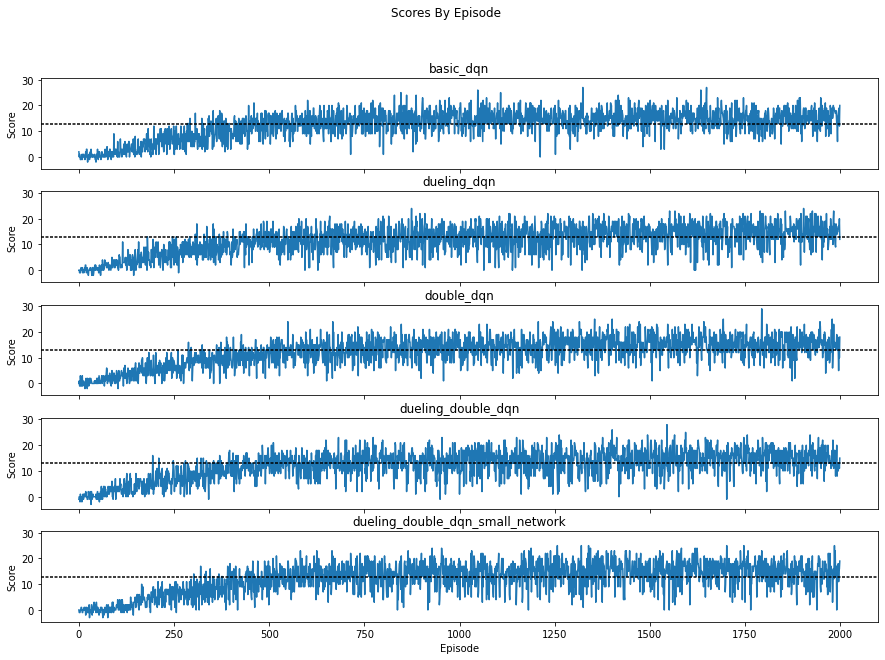

In [82]:
fig = plt.figure(figsize=(15,10))
gs = fig.add_gridspec(5, hspace=.25)
axes = gs.subplots(sharex=True, sharey=True)
fig.suptitle('Scores By Episode')
for experiment_name, ax in zip(scores.columns, axes):
    scores[experiment_name].plot(ax=ax)
    ax.axhline(y=13, color="black", dashes=(2,1))
    ax.set_title(experiment_name)
    ax.set(xlabel='Episode', ylabel='Score')

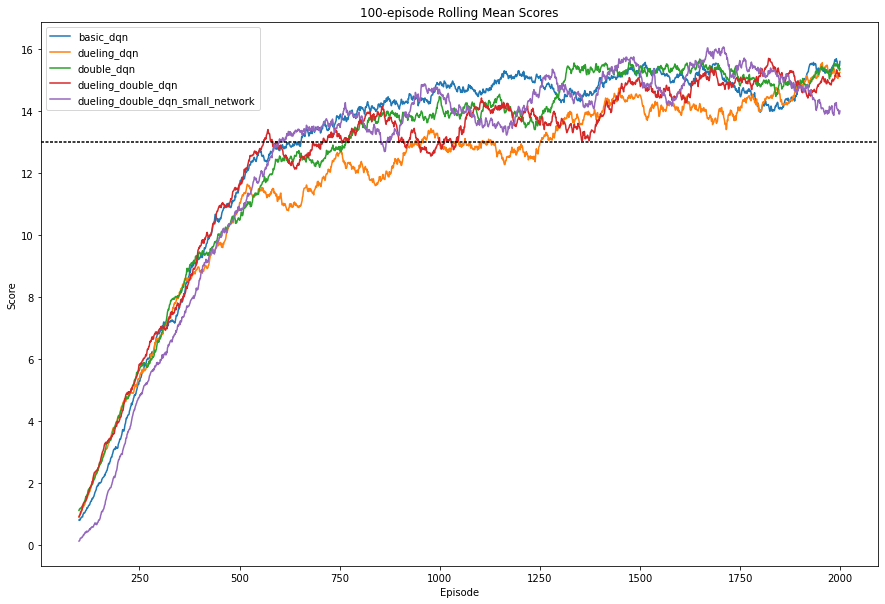

In [81]:
rolling_scores.plot(figsize=(15,10))
plt.axhline(y=13, color="black", dashes=(2,1))
plt.title('100-episode Rolling Mean Scores')
plt.ylabel("Score")
plt.xlabel("Episode")
plt.show()

In [97]:
print("Number of episodes to solve the environment by experiment:")
print((rolling_scores >= 13).idxmax())

Number of episodes to solve the environment by experiment:
basic_dqn                           641
dueling_dqn                         938
double_dqn                          766
dueling_double_dqn                  560
dueling_double_dqn_small_network    599
dtype: int64


## Reward Plot Analysis

As seen above, all of the agents solved the environment relatively quickly.  The combination of dueling and double DQN was the first to exceed the threshold, at episode 560.  However, it then later dipped below the threshold before going back above it.  In contrast, the smaller version of dueling DQN, as well as the basic Deep Q-Network both took a little longer to solve the environment, but after solving it their scores never dipped below the threshold of 13.  It is possible that this is due to the increased complexity of the double dueling DQN compared to its smaller version or to a basic network; because it has more weights to learn it has more expressive power, but also has more potential to continue "exploring" and therefore takes longer to become fully stable.

## Runtime Analysis

All experiments were performed in the Udacity workspace environment in cpu mode.  Assuming the environment does not change, the wall clock time should a relatively good predictor of how long training a specific architecture should take in genera.  As seen in the figure below, the additional complexity introduced by dueling and double Q-networks doesn't come for free: the training time increases significantly with the additional calculations and weights they introduce.  In particular, a dueling network has a more complex architecture and additional weights to train and shows a corresponding significant increase in runtime.  It's also worth noting that halving the hidden layer size reduced the training time by over 50% with only a minor decrease in final performance.  The smaller network also solved the environment quite quickly.  One possible explanation for this is that the Banana environment is simple enough to not need a particularly complex network to capture its subtleties and achieve near-optimal play.

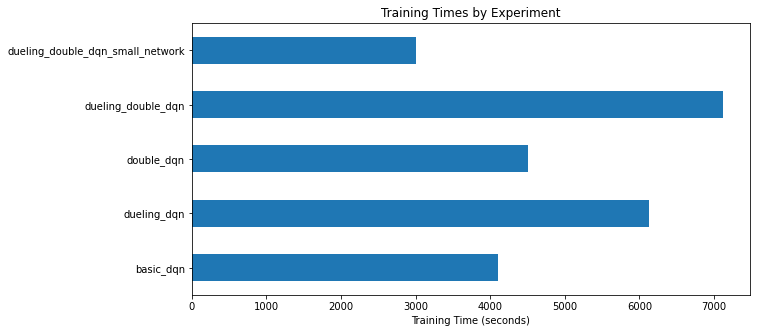

In [21]:
pd.Series(runtimes).plot(kind="barh", figsize=(10,5))
plt.xlabel("Training Time (seconds)")
plt.title("Training Times by Experiment")
plt.show()

# Ideas For Future Work

While I did explore a number of variations on a basic DQN during this project, there are also a large number of potential improvements that could be made.  The most basic would be experimenting with more hyperparameters.  In particular, varying epsilon, epsilon's decay rate, gamma, tau, and the learning rate can have a significant impact on the training process.  Another potential source of improvement would be variation in the architecture of the neural network.  I used a simple, single-hidden layer model but additional hidden layers as well as more variation in layer size could both have an impact on the performance of the agent.  Prioritized experience replay is another source of potential improvements.